In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
!pip install catboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

In [2]:
# Load the Excel files
df = pd.read_excel(r"/content/protein sequence in numreical.xlsx")

In [3]:
df.isnull().sum()

,0
Alanine(A),0
Arginine (R),0
Asparagine(N),0
Aspartic acid(D),0
Cysteine (C),0
Glutamine(Q),0
Glutamic acid(E),0
Glycine(G),0
Histidine(H),0
Isoleucine(I),0


In [4]:
df.head()

,Alanine(A),Arginine (R),Asparagine(N),Aspartic acid(D),Cysteine (C),Glutamine(Q),Glutamic acid(E),Glycine(G),Histidine(H),Isoleucine(I),...,Leucine(K),Methionine(M),Phenylalanine(F),Proline(P),Serine(S),Threonine(T),Tryptophan(W),Tyrosine(Y),Valine(V),class labels
0,24,27,25,24,2,28,19,34,10,14,...,28,4,23,32,52,27,5,16,19,HCoV-HKU1
1,10,8,11,7,3,5,3,11,2,21,...,12,8,21,7,16,18,6,10,19,HCoV-HKU1
2,9,10,32,21,15,6,5,19,9,28,...,18,2,39,17,42,10,4,33,24,HCoV-HKU1
3,24,27,25,24,2,28,19,34,10,14,...,28,4,23,32,52,27,5,16,19,HCoV-HKU1
4,10,8,11,7,3,5,3,11,2,21,...,12,8,21,7,16,18,6,10,19,HCoV-HKU1


In [5]:
a=df["class labels"].sort_values().unique()
a

array(['Alpha', 'Beta', 'Delta', 'Gamma', 'HCoV-HKU1', 'MERS-CoV',
       'Normal', 'omicron'], dtype=object)

In [6]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
# Assuming 'df' is your DataFrame
scaler = RobustScaler()

# Select numerical columns (excluding 'class labels')
numerical_cols = df.columns[:-1]

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df)

     Alanine(A)  Arginine (R)  Asparagine(N)  Aspartic acid(D)  Cysteine (C)  \
0     -0.964286     -0.636364      -0.917910            -0.900      -1.18750   
1     -1.214286     -1.500000      -1.126866            -1.325      -1.15625   
2     -1.232143     -1.409091      -0.813433            -0.975      -0.78125   
3     -0.964286     -0.636364      -0.917910            -0.900      -1.18750   
4     -1.214286     -1.500000      -1.126866            -1.325      -1.15625   
..          ...           ...            ...               ...           ...   
795   -0.732143     -0.818182      -1.037313            -0.850      -1.15625   
796   -0.928571     -0.409091      -0.589552            -0.850      -0.78125   
797   -0.517857     -0.227273      -1.186567            -0.925      -0.90625   
798   -1.178571     -1.318182      -1.171642            -0.875      -1.21875   
799   -1.053571     -0.727273      -0.977612            -0.975      -1.03125   

     Glutamine(Q)  Glutamic acid(E)  Gl

In [7]:
# Separate features and labels
X = df.drop(columns=['class labels'])
y = df['class labels']

In [8]:
# Encode labels
label_encoder = LabelEncoder()
# Fit and transform the class labels
y = label_encoder.fit_transform(y)

# Retrieve the mapping of labels to numeric values
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Display the encoded labels and the mapping
# print("Encoded Labels:", encoded_labels)
print("Label Mapping:", label_mapping)

# If you want to see the original class labels corresponding to encoded values
original_labels = label_encoder.inverse_transform(y)
# print("Original Labels:", original_labels)

Label Mapping: {'Alpha': 0, 'Beta': 1, 'Delta': 2, 'Gamma': 3, 'HCoV-HKU1': 4, 'MERS-CoV': 5, 'Normal': 6, 'omicron': 7}


In [9]:
# Feature selection function
def select_features(X, y, method, k=10):
    if method == 'ANOVA':
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
    else:
        raise ValueError("Unknown method: {}".format(method))

    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    feature_names = X.columns[selected_features]
    return X_new, selected_features, feature_names, selector

In [10]:
X_mi, selected_features_mi, feature_names_mi, _ = select_features(X, y, method='ANOVA', k=10)


In [11]:
# Define classifiers
classifiers = CatBoostClassifier(verbose=0)

In [12]:
# Function to evaluate classifiers
def evaluate_classifiers(X, y, classifiers):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = classifiers
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    # Handle multiclass confusion matrix
    specificity = [] # This line was indented unnecessarily, causing the error
    for i in range(cm.shape[0]):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)  # Handle potential division by zero

    results = { # Make sure to define 'name' somewhere if it's not a global variable
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': np.mean(specificity)  # Report average specificity
    }

    return results, cm


In [13]:
results_mi,cm_mi = evaluate_classifiers(X_mi, y, classifiers)

In [14]:

# Create a DataFrame for a single classifier
results_df = pd.DataFrame(results_mi, index=[0])
results_df = results_df.applymap(lambda x: x * 100 if isinstance(x, float) else x)

print(results_df)


   Accuracy  Precision  Sensitivity  Specificity
0     98.75  98.916667        98.75    99.829932


<ipython-input-14-864b1fecebdd>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: x * 100 if isinstance(x, float) else x)


In [15]:
results_df

,Accuracy,Precision,Sensitivity,Specificity
0,98.75,98.916667,98.75,99.829932


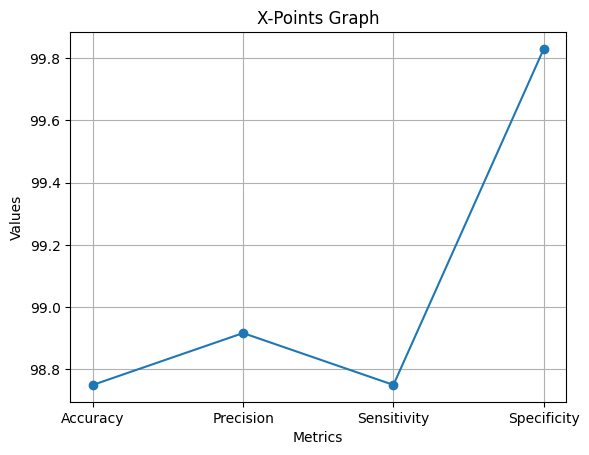

In [16]:
# prompt: Using dataframe results_df: X-Points grpah

import matplotlib.pyplot as plt

# Extract data from the DataFrame
metrics = results_df.columns.tolist()
values = results_df.values.tolist()[0]

# Create the X-Points graph
plt.plot(metrics, values, marker='o', linestyle='-')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('X-Points Graph')
plt.grid(True)
plt.show()


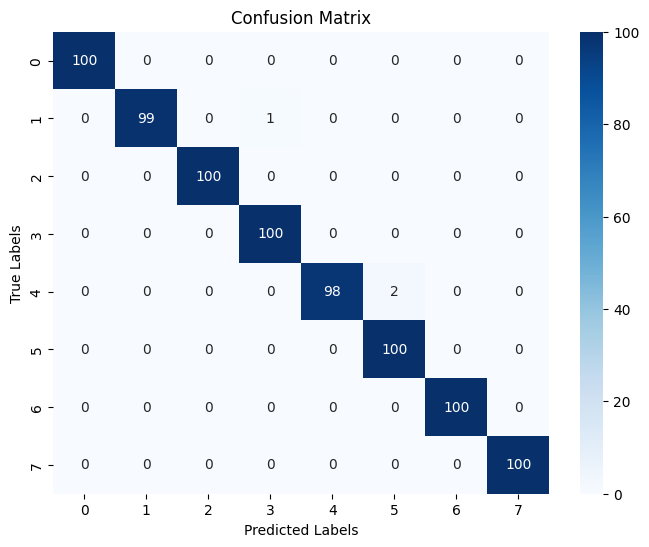

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_classifiers(X, y, classifiers):
    # Calculate and store the confusion matrix
    y_pred = classifiers.predict(X)
    cm = confusion_matrix(y, y_pred)  # Assuming 'confusion_matrix' is imported
    results=results_mi

    return results, cm  # Return the confusion matrix as well

results_mi, cm_mi = evaluate_classifiers(X_mi, y, classifiers)

# ... (rest of the code)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mi, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# prompt: save model

import joblib

# Save the trained model
joblib.dump(classifiers, 'MAAPRED.pkl')


['MAAPRED.pkl']

##Testing of the model

In [19]:
# prompt: test the model and show the 5 outputs random
# of the amino acids on same dataset.

# Load the saved model
loaded_model = joblib.load('MAAPRED.pkl')

# Assuming X and y are still available from the previous code
X_train, X_test, y_train, y_test = train_test_split(X_mi, y, test_size=0.2, random_state=42)

# Make predictions on the test set
y_pred = loaded_model.predict(X_test)

# Get 5 random indices
import random
random_indices = random.sample(range(len(y_test)), 5)

# Print predictions and true labels for the random samples
for i in random_indices:
  print(f"Sample {i+1}:")
  print(f"  Predicted Label: {label_encoder.inverse_transform([y_pred[i]])[0]}")
  print(f"  True Label: {label_encoder.inverse_transform([y_test[i]])[0]}")
  print()


Sample 138:
  Predicted Label: Delta
  True Label: Delta

Sample 17:
  Predicted Label: omicron
  True Label: omicron

Sample 31:
  Predicted Label: omicron
  True Label: omicron

Sample 104:
  Predicted Label: MERS-CoV
  True Label: MERS-CoV

Sample 127:
  Predicted Label: Beta
  True Label: Beta



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [20]:
!pip install lime
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt


In [21]:
from math import exp
explainer=lime.lime_tabular.LimeTabularExplainer(X_train,feature_names=X.columns,verbose=True,mode='classification')
exp=explainer.explain_instance(X_test[0],loaded_model.predict_proba,num_features=20)
exp.show_in_notebook(show_table=True)
print("Label Mapping:", label_mapping)

Intercept 0.12578811919247965
Prediction_local [0.13714478]
Right: 0.00042381100524294856


Label Mapping: {'Alpha': 0, 'Beta': 1, 'Delta': 2, 'Gamma': 3, 'HCoV-HKU1': 4, 'MERS-CoV': 5, 'Normal': 6, 'omicron': 7}


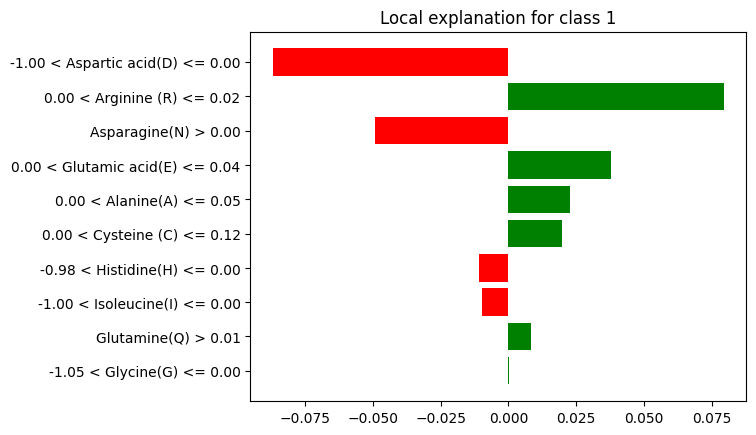

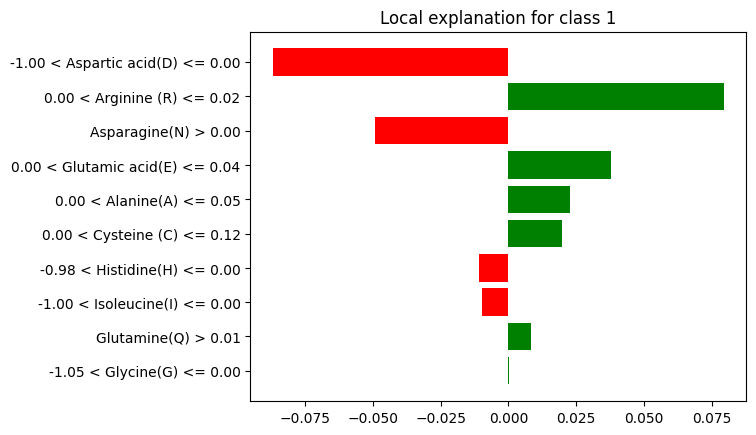

In [22]:
exp.as_pyplot_figure()